In [2]:
!pip install git+https://github.com/keras-team/keras.git -U
!pip install seqeval
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tensorflow-hub

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-k_mvq738
  Running command git clone -q https://github.com/keras-team/keras.git /tmp/pip-req-build-k_mvq738
  Stored in directory: /tmp/pip-ephem-wheel-cache-txji8t2z/wheels/da/a4/7e/6b7bd9af18cc2e23b8dd5ed6de07a7e13bd80a17214eb88932
Successfully built Keras
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, Lambda
from tensorflow.keras.layers import concatenate
# from sklearn.metrics import recall_score, precision_score
from seqeval.metrics import classification_report as classification_report_entity
from seqeval.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
print(tf.__version__)

2.0.0-alpha0


In [5]:
print(tf.keras.__version__)

2.2.4-tf


In [6]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


# Prepare data

In [0]:
# def read_file(filename):
#     """
#     read file
#     return format :
#     [ ['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O'] ]
#     """

#     f = open(filename, encoding="utf8")
#     sentences = []
#     sentence = []
#     for line in f:
#         if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
#             if len(sentence) > 0:
#                 sentences.append(sentence)
#                 sentence = []
#             continue
#         splits = line.split(' ')
#         label = splits[-1].replace("\n", "")
#         sentence.append([splits[0], label])

#     if len(sentence) > 0:
#         sentences.append(sentence)
#     return sentences

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
loc = '/content/gdrive/My Drive/tf2.0'

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

plt.style.use("ggplot")

data = pd.read_csv(os.path.join(loc, "iob-labeled-sent-final-020519.csv"))
data = data.fillna(method="ffill")
data.head(15)

,Unnamed: 0,para_index,sent,label,split_tag
0,0,0,By Jane Austen,O,train
1,1,1,Chapter 1,O,train
2,2,2,"It is a truth universally acknowledged, that a...",O,train
3,3,3,However little known the feelings or views of ...,O,train
4,4,4,"""My dear Mr Bennet,""",B-START,train
5,5,4,"""have you heard that Netherfield Park is...",I-START,train
6,6,5,Mr Bennet replied that he had not.,O,train
7,7,6,"""But it is,""",B-OTHER,train
8,8,6,"""for Mrs Long has just been here, and she told...",I-OTHER,train
9,9,7,Mr Bennet made no answer.,O,train


In [11]:
data.shape

(2747, 5)

In [12]:
tags = list(set(data["label"].values))
n_tags = len(tags); tags

['I-OTHER', 'B-START', 'I-START', 'B-OTHER', 'O']

In [13]:
data.head()

,Unnamed: 0,para_index,sent,label,split_tag
0,0,0,By Jane Austen,O,train
1,1,1,Chapter 1,O,train
2,2,2,"It is a truth universally acknowledged, that a...",O,train
3,3,3,However little known the feelings or views of ...,O,train
4,4,4,"""My dear Mr Bennet,""",B-START,train


In [0]:
num_para_in_group = 3

data['grouped_para_index'] = data['para_index'].apply(lambda x: int(x/num_para_in_group+1))

In [0]:
# class paragraphGetter(object):
    
#     def __init__(self, data):
#         self.n_para = 1
#         self.data = data
#         self.empty = False
#         agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["sent"].values.tolist(),
#                                                            s["split_tag"].values.tolist(),
#                                                            s["label"].values.tolist())]
#         self.grouped = self.data.groupby("para_index").apply(agg_func)
#         print(self.grouped)
#         self.paragraphs = [s for s in self.grouped]
    
#     def get_next(self):
#         try:
#             s = self.grouped["paragraph: {}".format(self.n_para)]
#             print(s)
#             self.n_para += 1
#             return s
#         except:
#             return None

class paragraphGetter(object):
    
    def __init__(self, data):
        self.n_para = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["sent"].values.tolist(),
                                                           s["split_tag"].values.tolist(),
                                                           s["label"].values.tolist())]
        self.grouped = self.data.groupby("grouped_para_index").apply(agg_func)
        print(self.grouped)
        self.paragraphs = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["grouped_paragraph: {}".format(self.n_para)]
            print(s)
            self.n_para += 1
            return s
        except:
            return None

In [16]:
getter = paragraphGetter(data)

grouped_para_index
1      [(By Jane Austen, train, O), (Chapter 1, train...
2      [(However little known the feelings or views o...
3      [("But it is,", train, B-OTHER), ("for Mrs Lon...
4      [("You want to tell me, and I have no objectio...
5      [("What is his name?", train, B-OTHER), ("Bing...
6      [("Oh! Single, my dear, to be sure! A single m...
7      [("Is that his design in settling here?", trai...
8      [("My dear, you flatter me. I certainly have h...
9      [("It is more than I engage for, I assure you....
10     [("I desire you will do no such thing. Lizzy i...
11     [("You mistake me, my dear. I have a high resp...
12     [("It will be no use to us, if twenty such sho...
13     [(Chapter 2, train, O), (Mr Bennet was among t...
14     [("We are not in a way to know what Mr Bingley...
15     [("No more have I,", train, B-OTHER), ("and I ...
16     [("Kitty has no discretion in her coughs,", tr...
17     [("Aye, so it is,", train, B-OTHER), ("and Mrs...
18     [("I 

In [0]:
paragraphs = getter.paragraphs

In [18]:
len(paragraphs)

707

In [19]:
print(paragraphs[0])

[('By Jane Austen', 'train', 'O'), ('Chapter 1', 'train', 'O'), ('It is a truth universally acknowledged, that a single man in possession of       a good fortune, must be in want of a wife.', 'train', 'O')]


In [20]:
maxlen = max([len(s) for s in paragraphs])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 8


In [0]:
max_len = 8
batch_size = 16
EPOCHS = 30
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
X_ori = [[w[0] for w in s] for s in paragraphs]

X = []
for seq in X_ori:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PAD")
    X.append(new_seq)
X[0]

['By Jane Austen',
 'Chapter 1',
 'It is a truth universally acknowledged, that a single man in possession of       a good fortune, must be in want of a wife.',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [23]:
len(X)

707

In [24]:
!pip install bert_embedding

In [0]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()


In [0]:
# def bertSentenceEmbeddingLayer(para):
#   return np.asarray(bert_embedding(para))[:,1]

In [41]:
def bertSentenceEmbedding(x):
  embeddings = []
  count = 0
  for para in x:
#     count = 0
#     print(para)
    para_all_embed = np.asarray(bert_embedding(para))[:,1]
  
    para_embed = []
    for embed in np.asarray(para_all_embed):
      count = 0
      all_embed = [0]*768
      for word_embed in embed:
        count += 1
        all_embed = all_embed + word_embed
#       print(count)
      sent_embed = all_embed/count
      para_embed.append(sent_embed)
      
    embeddings.append(para_embed)
#     print(np.asarray(bert_embedding(para)))
  return embeddings

xxx = [['hi hello world joyce','hi joyce'],['hi hello joyce','joyce']]

res = bertSentenceEmbedding(xxx)
print(np.asarray(res).shape)
# print(res[0])

(2, 2, 768)


In [0]:
X_embed = bertSentenceEmbedding(X)
np.save(os.path.join(loc, "X_g_embedding.npy"), X_embed)

In [0]:
X_embed = np.load(os.path.join(loc, "X_g_embedding.npy"))

In [30]:
print(np.asarray(X_embed).shape)

(707, 8, 768)


In [33]:
np.asarray(X_embed)[706]

array([[-0.30362565,  0.19630766,  0.16389419, ..., -0.49293816,
         0.39149393, -0.06356197],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       ...,
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329]])

In [34]:
tag2idx

{'B-OTHER': 3, 'B-START': 1, 'I-OTHER': 0, 'I-START': 2, 'O': 4}

In [0]:
np.save(os.path.join(loc, "tag2idx.npy"), tag2idx)

In [67]:
print(np.asarray(X_embed).shape)

(707, 8, 768)


In [0]:
# def bertSentenceEmbedding(x):
#   embeddings = []
#   count = 0
#   for para in x:
# #     count = 0
# #     print(para)
#     para_all_embed = np.asarray(bert_embedding(para))[:,1]
#     for embed in np.asarray(para_all_embed):
#       count = 0
#       all_embed = [0]*768
#       for word_embed in embed:
#         count += 1
#         all_embed = all_embed + word_embed
#       print(count)
#       sent_embed = all_embed/count
#       para_embed.append(sent_embed)
#     embeddings.append(para_embed)
# #     print(np.asarray(bert_embedding(para)))
#   return embeddings

# xxx = [['hi hello world shutao','hi shutao'],['hi hello shutao','shutao'] ]

# res = bertSentenceEmbedding(xxx)
# print(np.asarray(res).shape)
# print(res[0])

In [0]:
# para1 = ['This was invitation enough.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
# para2 = ['Mr Bennet replied that he had not.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
# para3 = ['"My dear Mr Bennet,"', '"have you heard that       Netherfield Park is let at last?"', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
# np.shape(np.asarray(bert_embedding(para3)))

In [0]:
# np.shape(bertSentenceEmbedding(X1))
# # array([[list([array([...]),array([..])]),list([array([..]),  array([..]),array([..])]), list([array([...]),array([..])])]])

# #2,3,2,2
# # array([[list([array([...]),array([..])]),list([array([..]),  array([..]),array([..])]), list([array([...]),array([..])]), list([array([..]), array([..])])

In [42]:
y = [[tag2idx[w[2]] for w in s] for s in paragraphs]

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y[0]

array([4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [0]:
train_index = set(data[data['split_tag']=='train']['grouped_para_index'].values)
valid_index = set(data[data['split_tag']=='validation']['grouped_para_index'].values)
test_index = set(data[data['split_tag']=='test']['grouped_para_index'].values)

In [70]:
len(X_embed)

707

In [56]:
len(y)

707

In [0]:
X_tr = [np.asarray(X_embed)[i-1] for i in train_index]
X_val = [np.asarray(X_embed)[i-1] for i in valid_index]
X_te = [np.asarray(X_embed)[i-1] for i in test_index]

y_tr = np.asarray([y[i-1] for i in train_index])
y_val = np.asarray([y[i-1] for i in valid_index])
y_te = np.asarray([y[i-1] for i in test_index])

In [69]:
len(X_tr)

568

In [70]:
len(X_val)

69

In [71]:
len(X_te)

72

In [72]:
from sklearn.model_selection import train_test_split

batch_size = 4

X_tr = X_tr[0:int(np.floor(len(X_tr)/batch_size)*batch_size)]
X_val = X_val[0:int(np.floor(len(X_val)/batch_size)*batch_size)]
y_tr = y_tr[0:int(np.floor(len(y_tr)/batch_size)*batch_size)]
y_val = y_val[0:int(np.floor(len(y_val)/batch_size)*batch_size)]
print("training sentences: ", len(X_tr), "validation sentences: ", len(X_val))
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

training sentences:  568 validation sentences:  68


In [59]:
# from sklearn.model_selection import train_test_split

# batch_size = 4

# X_tra, X_te, y_tra, y_te = train_test_split(np.asarray(X_embed), y, test_size=0.2, random_state=2019)

# X_tr, X_val, y_tr, y_val = train_test_split(X_tra, y_tra, test_size=0.1, random_state=2019)
# X_tr = X_tr[0:int(np.floor(len(X_tr)/batch_size)*batch_size)]
# X_val = X_val[0:int(np.floor(len(X_val)/batch_size)*batch_size)]
# y_tr = y_tr[0:int(np.floor(len(y_tr)/batch_size)*batch_size)]
# y_val = y_val[0:int(np.floor(len(y_val)/batch_size)*batch_size)]
# print("training sentences: ", len(X_tr), "validation sentences: ", len(X_val))
# y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

training sentences:  508 validation sentences:  56


In [73]:
X_tr[0]

array([[ 0.2912969 , -0.17903131,  0.10967472, ..., -0.19182503,
        -0.43881714,  0.23725479],
       [-0.15908244,  0.64495318,  0.22298899, ...,  0.17840026,
         0.12493649, -0.22940525],
       [-0.08114404,  0.23531241,  0.00488994, ..., -0.25501167,
         0.01424145,  0.12990276],
       ...,
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329]])

In [0]:
# X_tr[0]

array([[-0.13239855,  0.08427638,  0.21695995, ...,  0.0679633 ,
         0.14400986, -0.01412165],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       ...,
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329],
       [-0.36263752, -0.42318255,  0.41502503, ...,  0.25443158,
         0.20314312,  0.43733329]])

# Build model

In [0]:
# from tensorflow.keras.layers import concatenate
# # Function to build model
# def build_model():
#     input_text = Input(shape=(max_len,), dtype="string")
#     embedding = Lambda(bertSentenceEmbeddingLayer, output_shape=(None, 1024))(input_text)
# #     embedding = Embedding(2747, 500, input_length=max_len)(input_text)
#     x = Bidirectional(LSTM(units=512, return_sequences=True,
#                            recurrent_dropout=0.2, dropout=0.2))(input_text)
#     x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
#                                recurrent_dropout=0.2, dropout=0.2))(x)
#     x = concatenate([x, x_rnn])  # residual connection to the first biLSTMSS
#     out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

#     model = Model(input_text, out)
#     model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
#     model.summary()

#     return model

In [0]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=4)

filepath = os.path.join(loc, "fiction-elmo-iob-epoch-{epoch:02d}.hdf5")
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False,
                             mode='auto', period=1)
callbacks_list = [es, checkpoint]

In [75]:
from tensorflow.keras.layers import concatenate
# Function to build model
def build_model():
    input_text = Input(shape=(max_len,768))
#     embedding = Lambda(bertSentencembedding, output_shape=(None, 1024))(input_text)
#     embedding = Embedding(2747, 500, input_length=max_len)(input_text)
    x = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(input_text)
    x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)
    x = concatenate([x, x_rnn])  # residual connection to the first biLSTMSS
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

    model = Model(input_text, out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    model.summary()

    return model
  
model = build_model()

W0505 04:23:56.274562 140697709717376 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ff60069fe10>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0505 04:23:56.286113 140697709717376 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ff600692f60>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0505 04:23:56.781225 140697709717376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0505 04:23:57.508788 140697709717376 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 768)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 8, 1024)      5246976     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 8, 1024)      6295552     bidirectional[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 2048)      0           bidirectional[0][0]              
                                                                 bidirectional_1[0][0]        

In [0]:
# from tensorflow.keras.models import Sequential
# model = Sequential()

# model.add(LSTM(512, input_shape=(None,20)))
# model.add(Dense(n_tags, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())


# Fit model

In [76]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

Train on 568 samples, validate on 68 samples
Epoch 1/30
564/568 [============================>.] - ETA: 0s - loss: 0.3492 - accuracy: 0.8734
Epoch 00001: val_loss improved from inf to 0.14374, saving model to /content/gdrive/My Drive/tf2.0/fiction-elmo-iob-epoch-01.hdf5
568/568 [==============================] - 29s 52ms/sample - loss: 0.3470 - accuracy: 0.8743 - val_loss: 0.1437 - val_accuracy: 0.9504
Epoch 2/30
564/568 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9439
Epoch 00002: val_loss improved from 0.14374 to 0.11590, saving model to /content/gdrive/My Drive/tf2.0/fiction-elmo-iob-epoch-02.hdf5
568/568 [==============================] - 25s 43ms/sample - loss: 0.1535 - accuracy: 0.9441 - val_loss: 0.1159 - val_accuracy: 0.9522
Epoch 3/30
564/568 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9572
Epoch 00003: val_loss improved from 0.11590 to 0.11392, saving model to /content/gdrive/My Drive/tf2.0/fiction-elmo-iob-epoch-03.hdf5

In [0]:
# print(np.shape(X_tr))

# print(len(X_tr))
# print(len(X_tr[0]))
# print(type(X_tr))

# print(len(X_tr[0][0]))
# print(len(X_tr[1][0]))
# print(len(X_tr[2][0]))
# print(len(X_tr[3][0]))
# print(len(X_tr[0][0][0]))
# print(len(X_tr[1][0][0]))
# print(len(X_tr[3][0][0]))

# print(np.shape(np.asarray(X_tr)))
# # print(X_tr[0][0])


In [77]:
from keras.utils import plot_model

# plot_model(model, to_file='model_lstm_elmo.png')
print("Model built. Saved model.png")

Model built. Saved model.png


Using TensorFlow backend.


In [0]:
import time

timestr = time.strftime("%m%d_%H%M")

In [0]:
# np.save(os.path.join(loc, "idx2label_" + timestr + "-" + str(EPOCHS) + ".npy"), idx2label)
# np.save(os.path.join(loc, "word2idx_" + timestr + "_" + str(EPOCHS) + ".npy"), word2idx)

In [0]:
model_name = "fiction_lstm_elmo_v2_" + timestr + "_epoch" + str(EPOCHS)
model_name_path = os.path.join(loc, model_name + ".h5")
model.save(model_name_path)

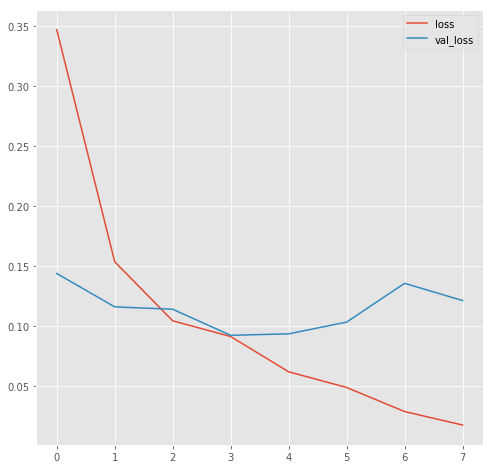

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend()
plt.show()

# Model evaluation

In [82]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

category_count = {'B-START':0, 'I-START':0, 'B-OTHER':0, 'I-OTHER':0, 'O':0}
total_count = 0

for sentence in paragraphs:
    for word in sentence:
        if word[2] in category_count.keys():
            category_count[word[2]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count / total_count) * 100, 2)))


B-START: 6.81%
I-START: 5.9%
B-OTHER: 36.8%
I-OTHER: 13.83%
O: 36.66%


In [0]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            #             print(p)
            out_i.append(idx2tag[p].replace("PAD", "O"))
        #           print(out_i)
        out.append(out_i)
    return out


def y2label(y):
    out = []
    for y_i in y:
        out_i = []
        for p in y_i:
            for p_i in p:
                out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [0]:
def evaluate_performance(X, y):
    pred_num = model.predict(np.array(X))
    pred = np.argmax(pred_num, axis=-1)
    pred_labels = pred2label(pred)
    labels = y2label(y)
    print(classification_report(labels, pred_labels))
    return pred

In [0]:
def evaluate_performance_v2(X, y):
    pred_num = model.predict(np.array(X[0:int(np.floor(len(X)/batch_size)*batch_size)]))
    pred = np.argmax(pred_num, axis=-1)
    pred_labels = pred2label(pred)
    y_num = y[0:int(np.floor(len(X)/batch_size)*batch_size)]
    y_labels = pred2label(y_num)
    print(classification_report(y_labels, pred_labels))
    return pred

In [0]:
idx2tag = {v: k for k, v in tag2idx.items()}

In [87]:
print(evaluate_performance(X_val, y_val))

           precision    recall  f1-score   support

    OTHER       0.90      0.93      0.91       107
    START       0.56      0.59      0.57        17

micro avg       0.85      0.88      0.87       124
macro avg       0.85      0.88      0.87       124

[[4 1 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [1 0 3 3 4 4 4 4]
 [3 3 3 4 4 4 4 4]
 [3 3 3 4 4 4 4 4]
 [3 0 3 3 4 4 4 4]
 [3 4 1 2 4 4 4 4]
 [4 1 2 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 4 1 4 4 4 4 4]
 [3 0 3 4 4 4 4 4]
 [4 1 4 4 4 4 4 4]
 [3 0 3 0 3 4 4 4]
 [3 3 0 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [3 0 3 0 4 4 4 4]
 [4 3 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 4 1 2 4 4 4 4]
 [3 3 3 4 4 4 4 4]
 [3 3 3 4 4 4 4 4]
 [3 3 3 4 4 4 4 4]
 [3 3 3 4 4 4 4 4]
 [4 3 3 4 4 4 4 4]
 [3 3 3 4 4 4 4 4]
 [3 3 0 3 0 4 4 4]
 [4 1 3 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 1 4 4 4 4 4 4]
 [4 1 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4]
 [4 1 3 4 4 4 4 4]
 [3 4 1 0 4 4 4 4]
 [3 0 3 4 4 4 4 4]
 [4 1 3 0 4 4 4 4]
 

In [0]:
y_test = y_te[0:int(np.floor(len(X_te)/batch_size)*batch_size)]
X_test = X_te[0:int(np.floor(len(X_te)/batch_size)*batch_size)]
# test_pred = evaluate_performance_v2(X_te, y_te)
pred_num = model.predict(np.array(X_test))
pred = np.argmax(pred_num, axis=-1)
pred_labels = pred2label(pred)
y_labels = pred2label(y_test)

In [89]:
print(classification_report(y_labels, pred_labels))

           precision    recall  f1-score   support

    OTHER       0.86      0.83      0.85       103
    START       0.53      0.62      0.57        26

micro avg       0.78      0.79      0.79       129
macro avg       0.79      0.79      0.79       129



In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(os.path.join(loc, "elmo_lstm_evaluation_model_v5_eva_test_conf.jpg"))
    plt.show()

In [0]:
# y_test = y_te[0:int(np.floor(len(X_te)/batch_size)*batch_size)]
# X_test = X_te[0:int(np.floor(len(X_te)/batch_size)*batch_size)]
# test_pred = evaluate_performance(X_test, y_test)
label_pred = []
idx_pred = []

for sentence in pred:
    for element in sentence:
        idx_pred.append(element)
        label_pred.append(idx2tag[element])

label_correct = []
idx_correct = []
for sentence in y_test:
    for element in sentence:
        idx_correct.append(element)
        label_correct.append(idx2tag[element])

In [92]:
idx2tag

{0: 'I-OTHER', 1: 'B-START', 2: 'I-START', 3: 'B-OTHER', 4: 'O'}

In [0]:
from sklearn.metrics import confusion_matrix
cm_with_o = confusion_matrix(label_correct, label_pred)

In [94]:
import pandas as pd
df = pd.DataFrame(cm_with_o)
df_wo_o = df.iloc[:-1, :-1]
cm = df_wo_o.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [95]:
labels = list(idx2tag.values())
labels.remove('O')
labels

['I-OTHER', 'B-START', 'I-START', 'B-OTHER']

In [96]:
labels_sorted = sorted(labels)
labels_sorted

['B-OTHER', 'B-START', 'I-OTHER', 'I-START']

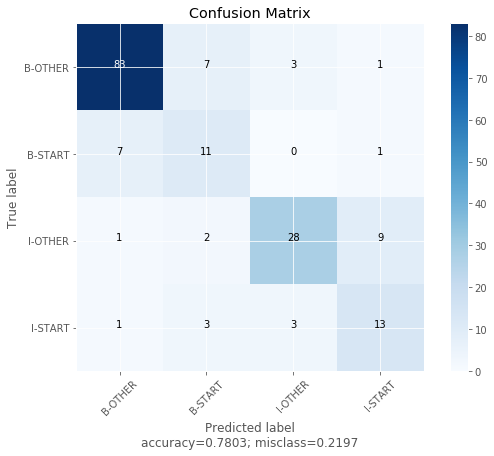

In [97]:
plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = labels_sorted,
                      title        = "Confusion Matrix")

In [98]:
from sklearn.metrics import classification_report as classification_report_all

print(classification_report_all(label_correct, label_pred,
                                labels=labels_sorted,
                                digits=3))

              precision    recall  f1-score   support

     B-OTHER      0.902     0.883     0.892        94
     B-START      0.478     0.550     0.512        20
     I-OTHER      0.824     0.683     0.747        41
     I-START      0.542     0.650     0.591        20

   micro avg      0.780     0.771     0.776       175
   macro avg      0.686     0.691     0.685       175
weighted avg      0.794     0.771     0.780       175

